<a href="https://colab.research.google.com/github/lauvsong/TITANIC_surviver_prediction/blob/main/TITANIC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TITANIC surviver prediction

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

TITANIC_PATH = '/content/gdrive/My Drive/handson/datasets/titanic/'
def load_titanic_data(filename, titanic_path=TITANIC_PATH):
  csv_path = os.path.join(titanic_path, filename)
  return pd.read_csv(csv_path)

In [3]:
import os
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

In [4]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


- Age 결측치 처리 필요
- Cabin 결측치 과반수 이상으로 분석 과정에서 제외

In [6]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
train_data['Survived'].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [8]:
train_data['Sex'].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [9]:
train_data['Pclass'].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [10]:
train_data['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

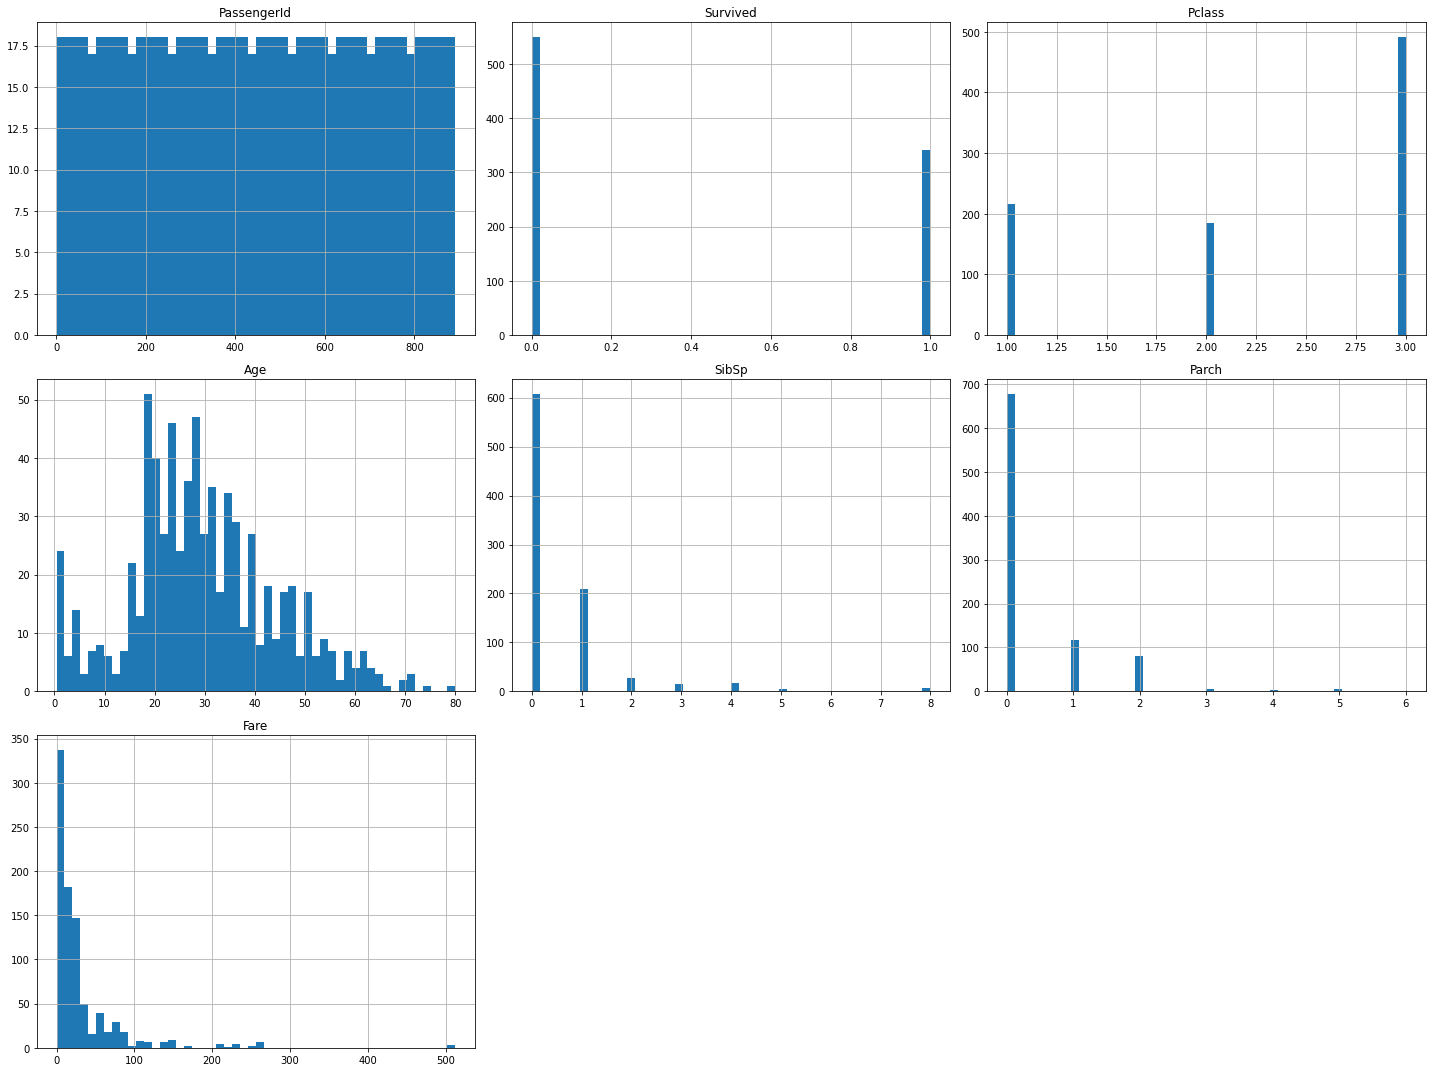

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

train_data.hist(bins=50, figsize=(20,15))
plt.tight_layout()

## EDA

#### 연속형 feature 상관관계 분석

In [12]:
corr_matrix = train_data.corr()
corr_matrix["Survived"].sort_values(ascending=False)

Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64

1. 요금과 생존율의 뚜렷한 양의 상관관계

2. Sibsp, Parch 각각으로는 거의 영향을 끼치지 않음

#### 범주형 feature 상관관계 분석

In [13]:
import seaborn as sns
sns.set()

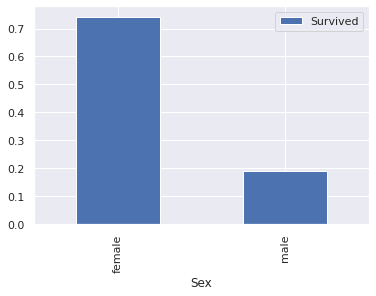

In [14]:
train_data[['Sex', 'Survived']].groupby(['Sex'], as_index=True).mean().plot.bar()
plt.show()

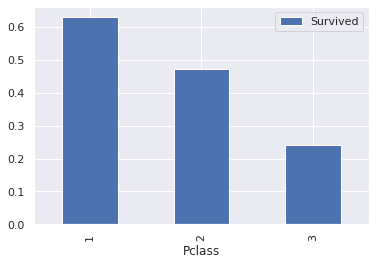

In [15]:
train_data[['Pclass', 'Survived']].groupby(['Pclass'], as_index=True).mean().plot.bar()
plt.show()

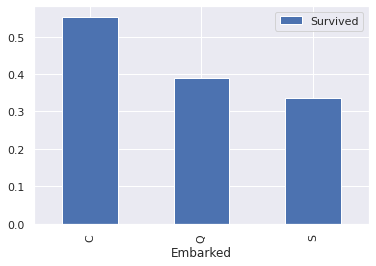

In [16]:
train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().plot.bar()
plt.show()

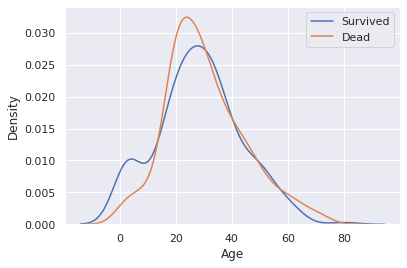

In [17]:
sns.kdeplot(train_data[train_data['Survived'] == 1]['Age'])
sns.kdeplot(train_data[train_data['Survived'] == 0]['Age'])
plt.legend(['Survived', 'Dead'])
plt.show()

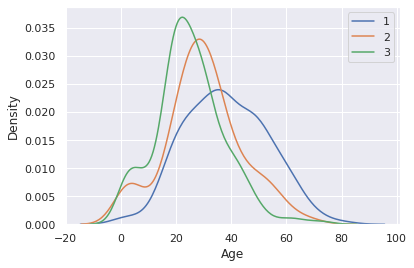

In [18]:
sns.kdeplot(train_data[train_data['Pclass'] == 1]['Age'])
sns.kdeplot(train_data[train_data['Pclass'] == 2]['Age'])
sns.kdeplot(train_data[train_data['Pclass'] == 3]['Age'])
plt.legend(['1', '2', '3'])
plt.show()

- 여성이 생존률이 높음
- 하위 클래스일 수록 생존률이 높음
- C 선착장이 비교적 생존률이 높음
- 나이가 어릴 수록 생존률이 높음

+) 하위 클래스에는 나이대가 어린 사람이 많았음

### 전처리
- 불필요한 컬럼 drop
- 결측치 대체
- 범주형 문자열 수치화
- feature 결합

In [19]:
from sklearn.preprocessing import OneHotEncoder

train = train_data.drop(['Cabin', 'Name', 'Ticket', 'PassengerId'], axis=1)
train = pd.get_dummies(train, columns=['Sex', 'Embarked', 'Pclass'])

In [20]:
train.head()

,Survived,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3
0,0,22.0,1,0,7.2500,0,1,0,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,1,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,0,1,1,0,0
4,0,35.0,0,0,8.0500,0,1,0,0,1,0,0,1


### 특성 공학 1) Alone feature 추가

In [21]:
train['family_size'] = train['SibSp'] + train['Parch']

train.corr()['Survived']

Survived       1.000000
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Sex_female     0.543351
Sex_male      -0.543351
Embarked_C     0.168240
Embarked_Q     0.003650
Embarked_S    -0.155660
Pclass_1       0.285904
Pclass_2       0.093349
Pclass_3      -0.322308
family_size    0.016639
Name: Survived, dtype: float64

In [22]:
train['Alone'] = 0
train.loc[train['family_size']==0, 'Alone'] = 1

In [23]:
train.corr()['Survived']

Survived       1.000000
Age           -0.077221
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Sex_female     0.543351
Sex_male      -0.543351
Embarked_C     0.168240
Embarked_Q     0.003650
Embarked_S    -0.155660
Pclass_1       0.285904
Pclass_2       0.093349
Pclass_3      -0.322308
family_size    0.016639
Alone         -0.203367
Name: Survived, dtype: float64

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


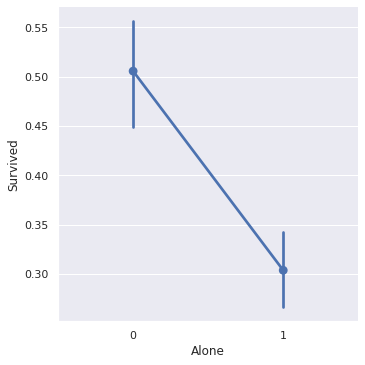

In [24]:
sns.factorplot(x='Alone', y='Survived', data=train)
plt.show()

- 혼자일 경우가 확실히 생존률이 낮다

#### 결측치 처리

In [25]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")
X = imputer.fit_transform(train)
imputer.statistics_

array([ 0.    , 28.    ,  0.    ,  0.    , 14.4542,  0.    ,  1.    ,
        0.    ,  0.    ,  1.    ,  0.    ,  0.    ,  1.    ,  0.    ,
        1.    ])

In [26]:
train = pd.DataFrame(X, columns=train.columns, index=train.index)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Survived     891 non-null    float64
 1   Age          891 non-null    float64
 2   SibSp        891 non-null    float64
 3   Parch        891 non-null    float64
 4   Fare         891 non-null    float64
 5   Sex_female   891 non-null    float64
 6   Sex_male     891 non-null    float64
 7   Embarked_C   891 non-null    float64
 8   Embarked_Q   891 non-null    float64
 9   Embarked_S   891 non-null    float64
 10  Pclass_1     891 non-null    float64
 11  Pclass_2     891 non-null    float64
 12  Pclass_3     891 non-null    float64
 13  family_size  891 non-null    float64
 14  Alone        891 non-null    float64
dtypes: float64(15)
memory usage: 104.5 KB


#### 특성 공학 2) 나이대 범주화

In [27]:
#### 나이대 범주화
train["AgeBucket"] = train["Age"] // 15 * 15
train[["AgeBucket", "Survived"]].groupby(["AgeBucket"]).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.337474
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


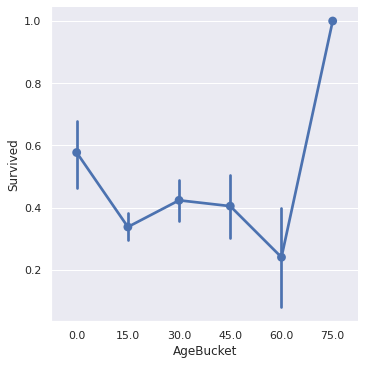

In [28]:
sns.factorplot(x='AgeBucket', y='Survived', data=train)
plt.show()

In [29]:
train.corr()['Survived']

Survived       1.000000
Age           -0.064910
SibSp         -0.035322
Parch          0.081629
Fare           0.257307
Sex_female     0.543351
Sex_male      -0.543351
Embarked_C     0.168240
Embarked_Q     0.003650
Embarked_S    -0.155660
Pclass_1       0.285904
Pclass_2       0.093349
Pclass_3      -0.322308
family_size    0.016639
Alone         -0.203367
AgeBucket     -0.028922
Name: Survived, dtype: float64

In [30]:
train = train.drop(['SibSp', 'Parch', 'family_size', 'Age'], axis=1)

In [31]:
train.head()

,Survived,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Pclass_1,Pclass_2,Pclass_3,Alone,AgeBucket
0,0.0,7.2500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,15.0
1,1.0,71.2833,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,30.0
2,1.0,7.9250,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,15.0
3,1.0,53.1000,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,30.0
4,0.0,8.0500,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,30.0


In [32]:
train.isnull().sum()

Survived      0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
Pclass_1      0
Pclass_2      0
Pclass_3      0
Alone         0
AgeBucket     0
dtype: int64

### 모델별 성능평가
- SVM Classifier
- Random Forest Classifier

In [33]:
y_train = train['Survived']
x_train = train.drop(['Survived'], axis=1)

In [34]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
x_train = scaler.fit_transform(x_train)
x_train.std()

0.8897879445612192

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_val_predict

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_predict(forest_clf, x_train, y_train, cv=10, method="predict_proba")

In [36]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.grid(True)
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [37]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto")
svm_scores = cross_val_predict(svm_clf, x_train, y_train, cv=10, method="decision_function")

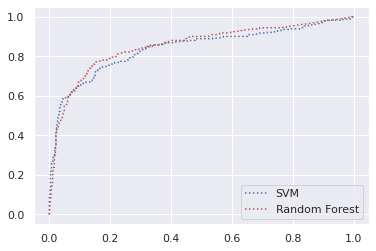

In [38]:
from sklearn.metrics import roc_curve

fpr_forest, tpr_forest, thresholds, = roc_curve(y_train, forest_scores[:,1])
fpr_svm, tpr_svm, thresholds, = roc_curve(y_train, svm_scores)

plt.plot(fpr_svm, tpr_svm, "b:", label="SVM")
plt.plot(fpr_forest, tpr_forest, "r:", label="Random Forest")

plt.legend()
plt.show()

In [39]:
from sklearn.metrics import f1_score

svm_pred = cross_val_predict(svm_clf, x_train, y_train, cv=10)
forest_pred = cross_val_predict(forest_clf, x_train, y_train, cv=10)

f1_score(y_train, svm_pred), f1_score(y_train, forest_pred)

(0.7191011235955055, 0.7567567567567567)

**Random Forest 채택**

### 파이프라인 구축
- dropper
- onehotencoder
- feature engineering



In [40]:
from sklearn.base import BaseEstimator, TransformerMixin

class Dropper(BaseEstimator, TransformerMixin):
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return X.drop(self.attribute_names, axis=1)

In [41]:
from sklearn.preprocessing import OneHotEncoder

class CombineAttributeAdder(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    X['family_size'] = X['SibSp'] + X['Parch']
    X['Alone'] = 0
    X.loc[X['family_size']==0, 'Alone'] = 1
    X["AgeBucket"] = X["Age"] // 15 * 15
    return X

In [42]:
class get_dummy(BaseEstimator, TransformerMixin):
  def __init__(self, attribute_names):
    self.attribute_names = attribute_names
  def fit(self, X, y=None):
    return self
  def transform(self, X):
    return pd.get_dummies(X, columns=['Sex', 'Embarked', 'Pclass'])

In [43]:
from sklearn.pipeline import Pipeline

full_pipeline = Pipeline([
  ('dropper_1', Dropper(['Cabin', 'Name', 'Ticket', 'PassengerId'])),
  ('attribs_adder', CombineAttributeAdder()),
  ('dropper_2', Dropper(['SibSp', 'Parch', 'family_size', 'Age'])),
  ("onehot", get_dummy(['Sex', 'Embarked', 'Pclass'])),
  ("imputer", SimpleImputer(strategy="median")),
  ("scaler", RobustScaler())
])

In [44]:
test = full_pipeline.fit_transform(test_data)
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [45]:
from sklearn.model_selection import RandomizedSearchCV

params = { 
    'n_estimators': list(range(10,100,10)),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

rfc = RandomForestClassifier(random_state=42)
rand_search = RandomizedSearchCV(estimator=rfc, param_distributions=params, cv=5)
rand_search.fit(x_train, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [46]:
rand_search.best_score_

0.8294269035214361

In [47]:
y_train = train_data['Survived']
x_train = train_data.drop(['Survived'], axis=1)
x_train = full_pipeline.fit_transform(x_train)

In [48]:
model = rand_search.best_estimator_
model.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [49]:
model.score(x_train, y_train)

0.8945005611672279

In [50]:
model = rand_search.best_estimator_
cross_val_score(model, x_train, y_train, cv=5).mean()

0.8271734354403364

In [51]:
x_train.shape, test.shape

((891, 11), (418, 11))

In [52]:
preds = model.predict(test).astype(int)

In [53]:
PassengerId = np.array(test_data['PassengerId']).astype(int)
solution = pd.DataFrame(preds, PassengerId, columns = ['Survived'])
solution.value_counts()

Survived
0           276
1           142
dtype: int64

In [54]:
solution.to_csv("/content/gdrive/My Drive/my_titanic_solution.csv", index_label=["PassengerId"])